# AT-LSTM, ATAE-LSTM для русского языка

В этом ноутбуке мы исследуем применение модели AT-LSTM, ATAE-LSTM для решения задачи аспектного анализа тональности на русском языке. В качестве основы мы берем ноутбуки 1-3.

In [1]:
import os
import zipfile
import random
import subprocess

import pandas as pd
import numpy as np
import torch
import gensim
import matplotlib.pyplot as plt
import seaborn as sns
import bs4

from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
from torch.utils.data import Dataset as TorchDataset
from torch.utils.data import DataLoader

from google.colab import drive

USE_GOOGLE_DRIVE = True

sns.set(font_scale=1.2)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Примонтируем наш гугл-диск, если мы решили его использовать.

In [2]:
if USE_GOOGLE_DRIVE:
    drive.mount('/content/drive')
    PATH_PREFIX = 'drive/My Drive/NLP/dialog-sent'
else:
    PATH_PREFIX = '..'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
DATA_PREFIX = os.path.join(PATH_PREFIX, 'data')
MODEL_PREFIX = os.path.join(PATH_PREFIX, 'models')
SCRIPT_PREFIX = os.path.join(PATH_PREFIX, 'src')

Зададим девайс для обучения.

In [4]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


Проинициализируем везде генераторы случайных чисел.

In [0]:
random_seed = 42
random_state = random_seed

def set_seed_everywhere(seed, cuda):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    if cuda:
        torch.cuda.manual_seed_all(seed)

set_seed_everywhere(random_seed, USE_GPU)

## Данные

Надо разобраться с данными и привести их в удобный для работы вид. У нас есть два датасета: отзывы о ресторанах и отзывы об автомобилях.

Сначала посмотрим на структуру датасета с отзывами о рестоанах. Существуют следующие аспекты:

* Food
* Interior
* Price
* Whole
* Service


Какие есть тональности:

* absence
* neutral
* positive
* negative
* both


Что касается датасета об автомобилях. Аспекты:

* Comfort
* Appearance
* Reliability
* Safety
* Driveability
* Whole
* Costs

Тональности те же.

В самой задаче требуется определять только тональности positive, negative, both.

Для использования векторов из RusVectōrēs нам потребуется выполнить надо всеми предложениями некоторый препроцессинг (указание частей речи). Поэтому воспользуемся их [скриптом](https://github.com/akutuzov/webvectors/blob/master/preprocessing/rus_preprocessing_udpipe.py).

In [6]:
!pip install wget
!pip install ufal.udpipe

In [0]:
def preprocess_sentence_rusvectores(script_path, text):
    """Предобработка текста для работы с rusvectores."""
    script = f'python "{script_path}"'
    ps = subprocess.Popen(script, 
                    stdin=subprocess.PIPE,
                    stdout = subprocess.PIPE, 
                    stderr = subprocess.PIPE, shell=True,
                    universal_newlines=True
    )
    out, err = ps.communicate(text)
    if ps.returncode != 0:
        raise Exception(err)
    return out

Данные предоставлены в формате xml. Для работы с ними будем использовать beautiful soup.

In [0]:
def xml2pandas(data_path, script_path):
    """Перевод исходного датасета в формате xml в pandas-датафрейм."""
    data_dict = {'review_id': [], 'text': []}

    with open(data_path, 'r') as inf:
        contents = inf.read()
        soup = bs4.BeautifulSoup(contents, 'xml')
        for review in tqdm(soup.find_all('review')):
            data_dict['review_id'].append(review['id'])

            text = review.find('text').text
            preprocessed_text = preprocess_sentence_rusvectores(script_path, text)
            data_dict['text'].append(preprocessed_text)

            aspect_categories = review.find('categories').find_all(
                'category'
            )
            for aspect_category in aspect_categories:
                if aspect_category['name'] in data_dict:
                    data_dict[aspect_category['name']].append(
                        aspect_category['sentiment']
                        )
                else:
                    data_dict[aspect_category['name']] = [
                        aspect_category['sentiment']
                    ]

    data = pd.DataFrame(data_dict)
    return data

In [0]:
# script_path = os.path.join(SCRIPT_PREFIX, 'data', 'rus_preprocessing_udpipe.py')

# restaurants_train_raw_path = os.path.join(
#     DATA_PREFIX, 'raw', "SentiRuEval-2015", 'SentiRuEval_rest_markup_train.xml'
# )

# restaurants_test_raw_path = os.path.join(
#     DATA_PREFIX, 'raw', 'SentiRuEval-2015', 'SentiRuEval_rest_markup_test.xml'
# )

# cars_train_raw_path = os.path.join(
#     DATA_PREFIX, 'raw', "SentiRuEval-2015", 'SentiRuEval_car_markup_train.xml'
# )

# cars_test_raw_path = os.path.join(
#     DATA_PREFIX, 'raw', 'SentiRuEval-2015', 'SentiRuEval_car_markup_test.xml'
# )

# restaurants_train_raw = xml2pandas(restaurants_train_raw_path, script_path)
# restaurants_test_raw = xml2pandas(restaurants_test_raw_path, script_path)
# cars_train_raw = xml2pandas(cars_train_raw_path, script_path)
# cars_test_raw = xml2pandas(cars_test_raw_path, script_path)

In [0]:
# restaurants_train_raw.head()

In [0]:
# cars_train_raw.head()

Чтобы правильно обучать нашу модель придется упростить данные до трех столбцов: `text`, `aspect`, `sentiment`.

In [0]:
# def raw2processed(data, filename):
#     """Приведение данных к удобному для обучения и тестирования виду."""
#     data_processed_dict = {'text': [], 'aspect': [], 'sentiment': []}
#     aspect_categories = list(data.columns[2:])
#     for i, row in data.iterrows():
#         for aspect_category in aspect_categories:
#             data_processed_dict['text'].append(row['text'])
#             data_processed_dict['aspect'].append(aspect_category)
#             data_processed_dict['sentiment'].append(row[aspect_category])

#     data_processed = pd.DataFrame(data_processed_dict)

#     data_path = os.path.join(DATA_PREFIX, 'processed', filename)
#     data_processed.to_csv(data_path, index=False)
#     return data_processed

In [0]:
# restaurants_train = raw2processed(restaurants_train_raw, 
#                                   'restaurants_ru_train.csv')
# restaurants_test = raw2processed(restaurants_test_raw, 
#                                  'restaurants_ru_test.csv')

# cars_train = raw2processed(cars_train_raw, 'cars_ru_train.csv')
# cars_test = raw2processed(cars_test_raw, 'cars_ru_test.csv')


# restaurants_all = pd.concat((restaurants_train, restaurants_test), 
#                             ignore_index=True)
# restaurants_all.to_csv(os.path.join(DATA_PREFIX, 'processed', 
#                                     'restaurants_ru.csv'), index=False)

# cars_all = pd.concat((cars_train, cars_test), 
#                             ignore_index=True)
# cars_all.to_csv(os.path.join(DATA_PREFIX, 'processed', 'cars_ru.csv'), 
#                 index=False)

# restaurants_all.head(10)

## Модели

Определим модели, над которыми будем экспериментировать и напишем цикл их обучения.



Вспомогательные слои.

In [0]:
class Permute(nn.Module):
    def __init__(self, dims):
        super(Permute, self).__init__()
        self.dims = dims
        
    def forward(self, x):
        x = x.permute(self.dims).contiguous()
        return x

class Swish(nn.Module):
    def __init__(self):
        super(Swish, self).__init__()
        
    def forward(self, x):
        return x * torch.sigmoid(x)

class Mish(nn.Module):
    def __init__(self):
        super(Mish, self).__init__()
        
    def forward(self, x):
        return x * torch.tanh(F.softplus(x))

AT-LSTM-модель:

In [0]:
class AT_LSTM(nn.Module):

    def __init__(
        self, num_aspects, embeddings_aspects_dim, hidden_dim, 
        num_sentiments, 
        vocab_size=None, embeddings_words_dim=None, embeddings_words_init=None
    ):
        super(AT_LSTM, self).__init__()

        train_from_scratch = (vocab_size is not None 
                              and embedding_words_dim is not None)
        use_pretrained = embeddings_words_init is not None
        if not(train_from_scratch or use_pretrained):
            raise ValueError('You should use pretrained vectors or '
                             'set vocab size and embeddings dim')

        if train_from_scratch:
            self.embeddings_words = nn.Embedding(
                vocab_size, embeddings_words_dim
            )
        else:
            self.embeddings_words = nn.Embedding.from_pretrained(
                embeddings_words_init
            )
            vocab_size, embeddings_words_dim = embeddings_words_init.size()

        self.lstm = nn.LSTM(
            embeddings_words_dim, hidden_dim,
            batch_first=True
        )

        self.embeddings_aspects = nn.Embedding(
            num_aspects, embeddings_aspects_dim
        )
        self.attention = nn.Sequential(
            nn.Linear(embeddings_aspects_dim + hidden_dim, 
                      embeddings_aspects_dim + hidden_dim),
            Permute([0, 2, 1]),     
            nn.BatchNorm1d(embeddings_aspects_dim + hidden_dim),
            Permute([0, 2, 1]),
            nn.Dropout(),
            nn.Tanh(),
            nn.Linear(embeddings_aspects_dim + hidden_dim, 1),
            nn.Softmax(dim=1),
        )

        self.sentence_representation = nn.Linear(
            hidden_dim + hidden_dim, hidden_dim, bias=False
        )
        self.drop = nn.Dropout()
        self.sentence_representation_nonlinearity = nn.Tanh()
        self.sentence_representation_to_sentiments = nn.Linear(
            hidden_dim, num_sentiments
        )

        # weights initializatioin
        torch.nn.init.xavier_uniform_(self.embeddings_aspects.weight)
        torch.nn.init.xavier_uniform_(self.sentence_representation.weight)
        torch.nn.init.xavier_uniform_(self.sentence_representation_to_sentiments.weight)

        
    def forward(self, texts, aspects, hidden=None):
        batch_size, seq_len = texts.size()
        # shape: [batch_size, seq_len] -> [batch_size, seq_len, embeddings_words_dim]
        embeddings_words_out = self.embeddings_words(texts)
        # shape: [batch_size] -> [batch_size, seq_len, embedding_aspects_dim]
        embeddings_aspects_out = self.embeddings_aspects(aspects)
        embeddings_aspects_out = torch.unsqueeze(embeddings_aspects_out, 1)
        embeddings_aspects_out = torch.repeat_interleave(
            embeddings_aspects_out, seq_len, 1
        )
        # shape: [batch_size, seq_len, embeddings_dim] -> [batch_size, seq_len, hidden_dim]
        lstm_output, hidden_state = self.lstm(embeddings_words_out, hidden)

        attention_input = torch.cat(
            [lstm_output, embeddings_aspects_out], dim=-1,
        )
        # shape: [batch_size, seq_len, hidden_dim + embeddings_aspects_dim] -> [batch_size, seq_len]
        attention_weights = self.attention(attention_input)
        weighted_lstm_output = lstm_output.permute(0, 2, 1) @ attention_weights
        weighted_lstm_output = torch.squeeze(weighted_lstm_output, dim=-1)
        sentence_representation = torch.cat([lstm_output[:, -1, :], 
                                             weighted_lstm_output], dim=-1)
        sentence_representation = self.sentence_representation(
            sentence_representation
        )
        sentence_representation = self.drop(sentence_representation)
        sentence_representation = self.sentence_representation_nonlinearity(
            sentence_representation
        )
        # shape: [batch_size, hidden_size] -> [batch_size, num_sentiments]
        sentiments_scores = self.sentence_representation_to_sentiments(
            sentence_representation
        )
        return sentiments_scores, hidden_state

ATAE-LSTM-модель.

In [0]:
class ATAE_LSTM(nn.Module):

    def __init__(
        self, num_aspects, embeddings_aspects_dim, hidden_dim, 
        num_sentiments, 
        vocab_size=None, embeddings_words_dim=None, embeddings_words_init=None
    ):
        super(ATAE_LSTM, self).__init__()

        train_from_scratch = (vocab_size is not None 
                              and embedding_words_dim is not None)
        use_pretrained = embeddings_words_init is not None
        if not(train_from_scratch or use_pretrained):
            raise ValueError('You should use pretrained vectors or '
                             'set vocab size and embeddings dim')

        if train_from_scratch:
            self.embeddings_words = nn.Embedding(
                vocab_size, embeddings_words_dim
            )
        else:
            self.embeddings_words = nn.Embedding.from_pretrained(
                embeddings_words_init
            )
            vocab_size, embeddings_words_dim = embeddings_words_init.size()

        self.embeddings_aspects = nn.Embedding(
            num_aspects, embeddings_aspects_dim
        )

        self.lstm = nn.LSTM(
            embeddings_words_dim + embeddings_aspects_dim, hidden_dim,
            batch_first=True
        )

        self.attention = nn.Sequential(
            nn.Linear(embeddings_aspects_dim + hidden_dim, 
                      embeddings_aspects_dim + hidden_dim),
            Permute([0, 2, 1]),     
            nn.BatchNorm1d(embeddings_aspects_dim + hidden_dim),
            Permute([0, 2, 1]),
            nn.Dropout(),
            nn.Tanh(),
            nn.Linear(embeddings_aspects_dim + hidden_dim, 1),
            nn.Softmax(dim=1),
        )

        self.sentence_representation = nn.Linear(
            hidden_dim + hidden_dim, hidden_dim, bias=False
        )
        self.drop = nn.Dropout()
        self.sentence_representation_nonlinearity = nn.Tanh()
        self.sentence_representation_to_sentiments = nn.Linear(
            hidden_dim, num_sentiments
        )

        # weights initializatioin
        torch.nn.init.xavier_uniform_(self.embeddings_aspects.weight)
        torch.nn.init.xavier_uniform_(self.sentence_representation.weight)
        torch.nn.init.xavier_uniform_(self.sentence_representation_to_sentiments.weight)

        
    def forward(self, texts, aspects, hidden=None):
        batch_size, seq_len = texts.size()
        # shape: [batch_size, seq_len] -> [batch_size, seq_len, embeddings_words_dim]
        embeddings_words_out = self.embeddings_words(texts)
        # shape: [batch_size] -> [batch_size, seq_len, embedding_aspects_dim]
        embeddings_aspects_out = self.embeddings_aspects(aspects)
        embeddings_aspects_out = torch.unsqueeze(embeddings_aspects_out, 1)
        embeddings_aspects_out = torch.repeat_interleave(
            embeddings_aspects_out, seq_len, 1
        )
        # shape: -> [batch_size, seq_len, embedding_words_dim + embedding_aspects_dim]
        embeddings = torch.cat(
            [embeddings_words_out, embeddings_aspects_out], dim=-1,
        )
        # shape: [batch_size, seq_len, embeddings_dim] -> [batch_size, seq_len, hidden_dim]
        lstm_output, hidden_state = self.lstm(embeddings, hidden)

        attention_input = torch.cat(
            [lstm_output, embeddings_aspects_out], dim=-1,
        )
        # shape: [batch_size, seq_len, hidden_dim + embeddings_aspects_dim] -> [batch_size, seq_len]
        attention_weights = self.attention(attention_input)
        weighted_lstm_output = lstm_output.permute(0, 2, 1) @ attention_weights
        weighted_lstm_output = torch.squeeze(weighted_lstm_output, dim=-1)
        sentence_representation = torch.cat([lstm_output[:, -1, :], 
                                             weighted_lstm_output], dim=-1)
        sentence_representation = self.sentence_representation(
            sentence_representation
        )
        sentence_representation = self.drop(sentence_representation)
        sentence_representation = self.sentence_representation_nonlinearity(
            sentence_representation
        )
        # shape: [batch_size, hidden_size] -> [batch_size, num_sentiments]
        sentiments_scores = self.sentence_representation_to_sentiments(
            sentence_representation
        )
        return sentiments_scores, hidden_state

Цикл обучения.

In [0]:
def train_loop(train_iter, val_iter, train_data, valid_data, 
               model, opt, scheduler, criterion, epochs, early_stopping):
    train_losses = []
    val_losses = []
    train_acc_values = []
    val_acc_values = []
    best_val_loss = 100
    best_val_acc = 0
    not_improves = 0
    for epoch in tqdm(range(1, epochs + 1)):
        train_loss = 0.0
        train_acc = 0
        model.train() 
        for batch in train_iter: 

            texts = batch.text.to(device=device)
            aspects = batch.aspect.to(device=device)
            sentiments = batch.sentiment.to(device=device)

            opt.zero_grad()
            preds, _ = model(texts, aspects)

            loss = criterion(preds, sentiments)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), grad_clipping_value)
            opt.step()
            train_loss += loss.item()

            pred_sentiments = torch.max(preds, dim=-1)[1]
            train_acc += np.sum(
                pred_sentiments.cpu().numpy() == sentiments.cpu().numpy()
            )

        train_loss /= len(train_data)
        train_losses.append(train_loss)
        train_acc /= len(train_data)
        train_acc_values.append(train_acc)

        val_loss = 0.0
        val_acc = 0
        model.eval()
        with torch.no_grad():
            for batch in val_iter:

                texts = batch.text.to(device=device)
                aspects = batch.aspect.to(device=device)
                sentiments = batch.sentiment.to(device=device)

                preds, _ = model(texts, aspects)   
                loss = criterion(preds, sentiments)
                val_loss += loss.item()

                pred_sentiments = torch.max(preds, dim=-1)[1]
                val_acc += np.sum(
                    pred_sentiments.cpu().numpy() == sentiments.cpu().numpy()
                )

        val_loss /= len(valid_data)
        val_acc /= len(valid_data)
        val_losses.append(val_loss)
        val_acc_values.append(val_acc)

        if val_loss < best_val_loss:
            not_improves = 0
            best_val_loss = val_loss
            torch.save(model.state_dict(), path_save)
            print('------SAVED------')
        else:
            not_improves += 1
            if not_improves == early_stopping:
                break
        
        scheduler.step()

        print(f'Epoch: {epoch}, '
              f'Training Loss*: {1000*train_loss:.5f}, '
              f'Validation Loss*: {1000*val_loss:.5f}, \n'
              f'Training Acc: {train_acc:.5f}, '
              f'Validation Acc: {val_acc:.5f}')

    return train_losses, val_losses, train_acc_values, val_acc_values

## Рестораны

Построим модели для отзывов о ресторанах.

### Подготовка данных

Определим поля в датасете для обучения.

In [0]:
TEXT = torchtext.data.Field(
    tokenize='spacy', batch_first=True, lower=False
)
ASPECT = torchtext.data.Field(sequential=False, batch_first=True, 
                              unk_token=None)
SENTIMENT = torchtext.data.LabelField(batch_first=True)

In [0]:
fields = [('text', TEXT), ('aspect', ASPECT), ('sentiment', SENTIMENT)]

In [20]:
PROCESSED_PREFIX = os.path.join(DATA_PREFIX, 'processed')

# отфильтруем только определенные тональности
remain_sentiments = ['positive', 'negative', 'both']

temp_train = pd.read_csv(os.path.join(PROCESSED_PREFIX, 
                                      'restaurants_ru_train.csv'))
temp_train = temp_train[temp_train['sentiment'].isin(remain_sentiments)]
temp_train.to_csv(os.path.join(PROCESSED_PREFIX, 
                               'restaurants_ru_train_filtered.csv'), 
                  index=False)

temp_test = pd.read_csv(os.path.join(PROCESSED_PREFIX, 
                                     'restaurants_ru_test.csv'))
temp_test = temp_test[temp_test['sentiment'].isin(remain_sentiments)]
temp_test.to_csv(os.path.join(PROCESSED_PREFIX, 
                              'restaurants_ru_test_filtered.csv'), 
                 index=False)

temp_all = pd.read_csv(os.path.join(PROCESSED_PREFIX,
                                    'restaurants_ru.csv'))
temp_all = temp_all[temp_all['sentiment'].isin(remain_sentiments)]
temp_all.to_csv(os.path.join(PROCESSED_PREFIX,
                             'restaurants_ru_filtered.csv'), 
                index=False)

restaurants_train_all = torchtext.data.TabularDataset(
    path=os.path.join(PROCESSED_PREFIX, 'restaurants_ru_train_filtered.csv'), 
    format = 'csv', fields=fields, skip_header=True
)
restaurants_test = torchtext.data.TabularDataset(
    path=os.path.join(PROCESSED_PREFIX, 'restaurants_ru_test_filtered.csv'), 
    format = 'csv', fields=fields, skip_header=True
)
restaurants_all = torchtext.data.TabularDataset(
    path=os.path.join(PROCESSED_PREFIX, 'restaurants_ru_filtered.csv'), 
    format = 'csv', fields=fields, skip_header=True
)

print(vars(restaurants_train_all.examples[0]))

{'text': ['день_PROPN', '8-й_ADJ', 'март_NOUN', 'проходить_VERB', 'можно_ADV', 'и_PART', 'итог_NOUN', 'подводить_VERB', 'решать_VERB', 'писать_VERB', 'отзыв_NOUN', 'о_ADP', 'ресторан_NOUN', 'в_ADP', 'который_PRON', 'отмечать_VERB', 'прекрасный_ADJ', 'весений_NOUN', 'праздник_NOUN', 'прочитывать_VERB', 'отзыв_NOUN', 'edik077_NUM', 'и_CCONJ', 'rules77777ь_NOUN', 'понимать_VERB', 'что_PRON', 'либо_CCONJ', 'мы_PRON', 'быть_AUX', 'вразный_ADJ', 'ресторан_NOUN', 'либо_CCONJ', 'в_ADP', 'ребята_NOUN', 'что', '-', 'то_NOUN', 'незаладиться_VERB', 'но_CCONJ', 'теперь_ADV', 'о_ADP', 'ресторан_NOUN', 'столик_NOUN', 'бронировать_VERB', 'заранее_ADV', 'и_CCONJ', 'делать_VERB', 'так_ADV', 'как_SCONJ', 'предлагать_VERB', 'администратор_NOUN', 'то_VERB', 'делать_VERB', 'предварительный_ADJ', 'заказ_NOUN', 'когда_SCONJ', 'приходить_VERB', 'видеть_VERB', 'полностью_ADV', 'заполненый_ADJ', 'ресторан_NOUN', 'понимать_VERB', 'что_SCONJ', 'совет_NOUN', 'мы_PRON', 'давать_VERB', 'действительно_ADV', 'правильны

Посмотрим на баланс классов

In [21]:
np.unique(temp_all.sentiment, return_counts=True)

(array(['both', 'negative', 'positive'], dtype=object),
 array([ 274,  212, 1185]))

Как видим, объектов классов neutral, both мало, нам придется подстроить веса в лоссе, чтобы лучше обучаться на эти элементы.

Разделим данные на обучение и валидацию (для early stopping).

In [0]:
restaurants_train, restaurants_valid = restaurants_train_all.split(
    split_ratio=0.8, random_state=random.seed(random_state), 
    strata_field='sentiment', stratified=True
)

Теперь надо построить словарь для нашего датасета. Имеет смысл попробовать несколько возможных векторов.

In [0]:
TEXT.build_vocab(restaurants_all)
ASPECT.build_vocab(restaurants_train)
SENTIMENT.build_vocab(restaurants_train)

In [24]:
print(f'Size of TEXT vocabulary: {len(TEXT.vocab)}')
print(f'Size of ASPECT vocabulary: {len(ASPECT.vocab)}')
print(f'Size of SENTIMENT vocabulary: {len(SENTIMENT.vocab)}')

Size of TEXT vocabulary: 6017
Size of ASPECT vocabulary: 5
Size of SENTIMENT vocabulary: 3


Надо подгрузить векторы с диска и создать словарь.

In [0]:
epsilon = 0.01
word2vec_path = os.path.join(DATA_PREFIX, 'raw', 'word2vec', 
                            'ruscorpora_upos_cbow_300_20_2019.txt')
fasttext_path = os.path.join(DATA_PREFIX, 'raw', 'fasttext', 
                            'ruscorpora_none_fasttextskipgram_300_2_2019.txt')
vectors = torchtext.vocab.Vectors(
    word2vec_path, 
    unk_init=lambda x: torch.nn.init.uniform_(x, -epsilon, epsilon)
)
TEXT.vocab.set_vectors(vectors.stoi, vectors.vectors, vectors.dim)

Чтобы понять как подобные файлы с векторами получить можно посмотреть [туториал](https://github.com/akutuzov/webvectors/blob/master/preprocessing/rusvectores_tutorial.ipynb). Сначала потребуется перевести модели в формат gensim, а затем сохранить их в wv формате следующим образом:
```python
gensim_model.wv.save_word2vec_format(path_to_embeddings_file)
```

Также для понимания может быть полезен следующий [ответ](https://stackoverflow.com/questions/49710537/pytorch-gensim-how-to-load-pre-trained-word-embeddings).

### Обучение модели

Теперь нам предстоит обучить модель.

Напишем итератор.

In [0]:
batch_size = 64

train_iter, val_iter, test_iter = torchtext.data.BucketIterator.splits(
        (restaurants_train, restaurants_valid, restaurants_test),
        batch_sizes=(batch_size, batch_size, 1),
        sort=True,
        sort_key=lambda x: len(x.text),
        sort_within_batch=True,
        device=device,
        repeat=False
)

In [38]:
num_aspects = len(ASPECT.vocab)
embeddings_aspects_dim = 300
hidden_dim = 300
num_sentiments = len(SENTIMENT.vocab)
embeddings_words_init = TEXT.vocab.vectors

set_seed_everywhere(random_seed, USE_GPU)
model = ATAE_LSTM(
    num_aspects, embeddings_aspects_dim, hidden_dim, num_sentiments, 
    embeddings_words_init=embeddings_words_init
)
model

ATAE_LSTM(
  (embeddings_words): Embedding(6017, 300)
  (embeddings_aspects): Embedding(5, 300)
  (lstm): LSTM(600, 300, batch_first=True)
  (attention): Sequential(
    (0): Linear(in_features=600, out_features=600, bias=True)
    (1): Permute()
    (2): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Permute()
    (4): Dropout(p=0.5, inplace=False)
    (5): Tanh()
    (6): Linear(in_features=600, out_features=1, bias=True)
    (7): Softmax(dim=1)
  )
  (sentence_representation): Linear(in_features=600, out_features=300, bias=False)
  (drop): Dropout(p=0.5, inplace=False)
  (sentence_representation_nonlinearity): Tanh()
  (sentence_representation_to_sentiments): Linear(in_features=300, out_features=3, bias=True)
)

In [0]:
model = model.to(device=device)
learning_rate = 5e-6
early_stopping = 1000
grad_clipping_value = 1
l2_coef = 1e-3
epochs = 300

opt = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_coef)
scheduler = optim.lr_scheduler.StepLR(opt, step_size=10, gamma=1)
# Так как каждого класса сильно разное количество, 
# то необходимо сделать подстройку весов
weight = torch.tensor([1., 2, 2], device=device)
criterion = nn.CrossEntropyLoss(weight=weight)
path_save = os.path.join(MODEL_PREFIX, 'at_lstm', 'at_lstm_ru.pt')

In [40]:
set_seed_everywhere(random_seed, USE_GPU)
train_losses, val_losses, train_acc, val_acc = train_loop(
    train_iter, val_iter, restaurants_train, restaurants_valid,
    model, opt, scheduler, criterion, 
    epochs, early_stopping
)

------SAVED------
Epoch: 1, Training Loss*: 18.61836, Validation Loss*: 20.22216, 
Training Acc: 0.20274, Validation Acc: 0.15854
------SAVED------
Epoch: 2, Training Loss*: 18.51189, Validation Loss*: 20.08575, 
Training Acc: 0.26524, Validation Acc: 0.26220
------SAVED------
Epoch: 3, Training Loss*: 18.20914, Validation Loss*: 19.95430, 
Training Acc: 0.35518, Validation Acc: 0.40854
------SAVED------
Epoch: 4, Training Loss*: 18.20324, Validation Loss*: 19.82606, 
Training Acc: 0.40701, Validation Acc: 0.54268
------SAVED------
Epoch: 5, Training Loss*: 17.94868, Validation Loss*: 19.69973, 
Training Acc: 0.45732, Validation Acc: 0.61585
------SAVED------
Epoch: 6, Training Loss*: 17.92375, Validation Loss*: 19.57834, 
Training Acc: 0.53049, Validation Acc: 0.68293
------SAVED------
Epoch: 7, Training Loss*: 17.75760, Validation Loss*: 19.46210, 
Training Acc: 0.58384, Validation Acc: 0.69512
------SAVED------
Epoch: 8, Training Loss*: 17.60346, Validation Loss*: 19.34700, 
Trainin

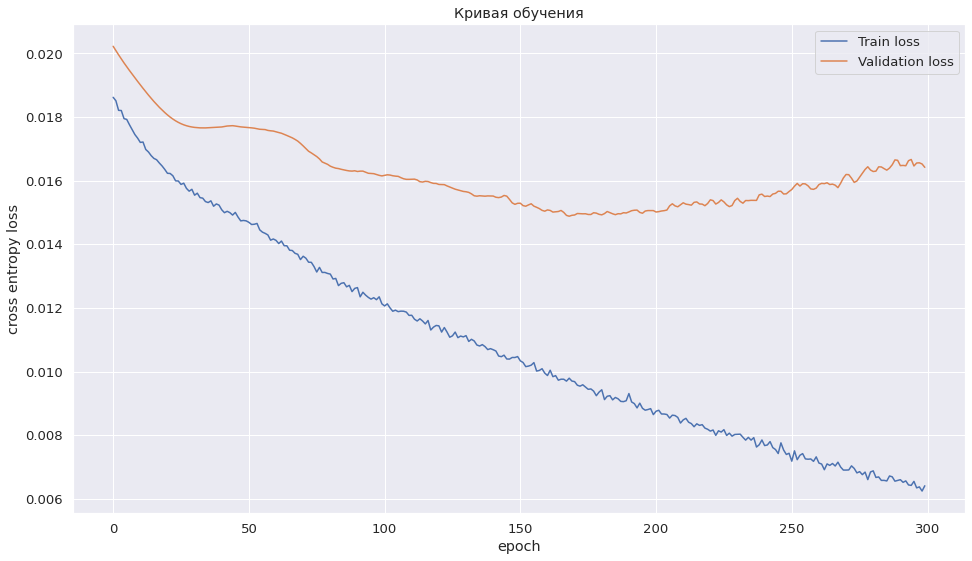

In [41]:
plt.figure(figsize=(16, 9))
finished_epochs = len(train_losses)
plt.plot(np.arange(finished_epochs), train_losses, label='Train loss')
plt.plot(np.arange(finished_epochs), val_losses, label='Validation loss')
plt.xlabel('epoch')
plt.ylabel('cross entropy loss')
plt.title('Кривая обучения')
plt.legend()
plt.show()

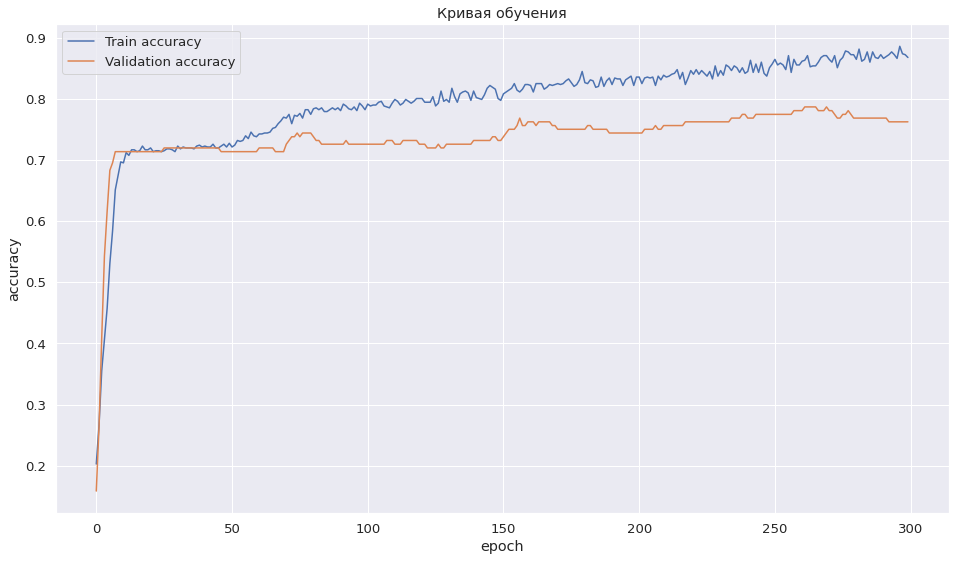

In [42]:
plt.figure(figsize=(16, 9))
finished_epochs = len(train_losses)
plt.plot(np.arange(finished_epochs), train_acc, label='Train accuracy')
plt.plot(np.arange(finished_epochs), val_acc, label='Validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Кривая обучения')
plt.legend()
plt.show()

### Измерения качества модели

In [43]:
model.load_state_dict(torch.load(path_save))

<All keys matched successfully>

In [0]:
model.eval()

all_preds = []
all_answers = []
with torch.no_grad():
    for batch in test_iter:

        texts = batch.text.to(device=device)
        aspects = batch.aspect.to(device=device)
        sentiments = batch.sentiment.to(device=device)

        preds_scores, _ = model(texts, aspects)
        preds = torch.max(preds_scores, dim=-1)[1]
        all_preds += preds.tolist()
        all_answers += sentiments.tolist()

all_preds = np.array(all_preds)
all_answers = np.array(all_answers)

In [45]:
accuracy = accuracy_score(all_preds, all_answers)

print(f'Accuracy: {accuracy:.5f}')

Accuracy: 0.71915


Тем не менее, на соревновании измерялось качество при помощи F-меры. Попробуем повторить процедуру, чтобы можно было сравнить с результатами участников.

In [0]:
all_preds = {key: [] for key in ASPECT.vocab.itos}
all_answers = {key: [] for key in ASPECT.vocab.itos}

with torch.no_grad():
    # batch_size = 1
    for batch in test_iter:
        texts = batch.text.to(device=device)
        aspects = batch.aspect.to(device=device)
        aspect = ASPECT.vocab.itos[aspects[0].item()]
        sentiments = batch.sentiment.to(device=device)

        preds_scores, _ = model(texts, aspects)
        preds = torch.max(preds_scores, dim=-1)[1]
        all_preds[aspect].append(preds.tolist()[0])
        all_answers[aspect].append(sentiments.tolist()[0])

In [47]:
SENTIMENT.vocab.stoi

defaultdict(<function torchtext.vocab._default_unk_index>,
            {'both': 1, 'negative': 2, 'positive': 0})

In [48]:
avgs = []
for aspect in ASPECT.vocab.itos:
    preds = all_preds[aspect]
    answers = all_answers[aspect]
    p,r,f,_ = precision_recall_fscore_support(answers, preds, average='macro')
    print(f'{aspect}: precision: {p:.3f}, recall: {r:.3f}, F1: {f:.3f}')
    avgs.append(f)
print(f'Average F1: {sum(avgs)/len(avgs):.3f}')

Whole: precision: 0.642, recall: 0.506, F1: 0.541
Food: precision: 0.510, recall: 0.433, F1: 0.447
Service: precision: 0.541, recall: 0.518, F1: 0.522
Interior: precision: 0.452, recall: 0.358, F1: 0.349
Price: precision: 0.435, recall: 0.386, F1: 0.370
Average F1: 0.446


Видим совсем не впечатляющие цифры. Лучший результат на соревновании был около $0.458$.

Как можно улучшить результаты:
1. Контролировать не лосс на валидации, а именно Average F1 и по нему делать early stopping.
2. При разделении на тест и валидацию делить по группам. То есть делать так, чтобы все элементы одного отзыва попадали или в обучение или в валидацию.
2. Поэспериментировать с моделью (попробовать FasText).

## Автомобили

Построим модели для отзывов об автомобилях.

### Выводы

1. 
2. 
3. 